In [2]:
# 0. LOAD PACKAGES

import networkx
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import matplotlib.patches as mpatches

In [2]:
# 1. LOAD DATA

# Load csv-file which was created in the file 'exploration_and_preprocessing.ipynb'
airports_df = pd.read_csv('*/Airports_IDs_Countries.csv')

# Load airline routes
routes_df = pd.read_csv('*/Full_Merge_of_All_Unique_Routes.csv')

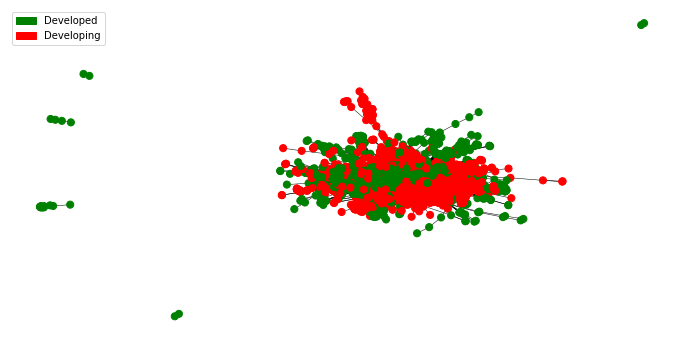

In [7]:
# 2. AIRLINE ROUTES

# Gather country names of countries declared by the United Nations as being 'developed' 
developed_countries = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg',
             'Netherlands', 'Portugal', 'Spain', 'Sweden', 'United Kingdom', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
             'Estonia', 'Hungary', 'Latvia', 'Lithuania', 'Malta','Poland','Romania','Slovakia','Slovenia','Iceland','Norway',
             'Switzerland','Australia','Canada','Japan','New Zealand','United States']

# Select only airports in developed countries
airports_developed_df = airports_df[airports_df['Country'].isin(developed_countries)]
developed_list = airports_developed_df['Airport_ID'].values.tolist()

# Create a network based on the airline routes
# this step can take a while to process
G = networkx.from_pandas_edgelist(routes_df, 'Departure', 'Destination', 'Airline ID')

# Color the network nodes (= airports) according to whether they are located in a developed country (= green) or not (= red)
color_map = []
for node in G:
    if node in developed_list:
        color_map.append('green')
    else:
        color_map.append('red')

# Plot network (depiction might vary across different runs since networkx.draw involves a certain degree of randomness)
plt.figure(figsize=(12,6))
red_patch = mpatches.Patch(color='red', label='Developing')
green_patch = mpatches.Patch(color='green', label='Developed')
plt.legend(handles=[green_patch, red_patch])
networkx.draw(G, with_labels=False, arrows=True, node_color=color_map, node_size=50, width=.5)

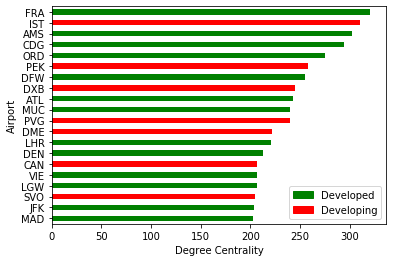

In [8]:
# 3. DEGREE CENTRALITY

# Compute degree centrality for each node of the network
networkx.degree(G)

# Organize airports according to their degree centrality in descending order
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)
degree_df = pd.DataFrame(G.nodes(data='degree'), columns=['node', 'degree'])
degree_df = degree_df.sort_values(by='degree', ascending=False)


# Plot 20 most important airports according to degree centrality
num_nodes_to_inspect = 20

color_map = []
for node in degree_df['node']:
    if node in developed_list:
        color_map.append('green')
    else:
        color_map.append('red')
        
degree_df[:num_nodes_to_inspect].plot(x='node', y='degree', kind='barh', color=color_map).invert_yaxis()
plt.xlabel('Degree Centrality')
plt.ylabel('Airport')
red_patch = mpatches.Patch(color='red', label='Developing')
green_patch = mpatches.Patch(color='green', label='Developed')
plt.legend(handles=[green_patch, red_patch])
plt.show()

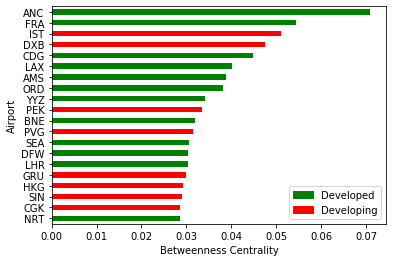

In [9]:
# 4. BETWEENNESS CENTRALITY 
# this step can take a while to process

# Compute betweenness centrality for each node of the network
networkx.betweenness_centrality(G)

# Organize airports according to their betweenness centrality in descending order
betweenness_centrality = networkx.betweenness_centrality(G)
networkx.set_node_attributes(G, name='betweenness', values=betweenness_centrality)
betweenness_df = pd.DataFrame(G.nodes(data='betweenness'), columns=['node', 'betweenness'])
betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)

# Plot 20 most important airports according to degree centrality
num_nodes_to_inspect = 20

color_map = []
for node in betweenness_df['node']:
    if node in developed_list:
        color_map.append('green')
    else:
        color_map.append('red')

betweenness_df[:num_nodes_to_inspect].plot(x='node', y='betweenness', kind='barh', color=color_map).invert_yaxis()
plt.xlabel('Betweenness Centrality')
plt.ylabel('Airport')
red_patch = mpatches.Patch(color='red', label='Developing')
green_patch = mpatches.Patch(color='green', label='Developed')
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [47]:
# 5. ISOLATED CLUSTERS
# The network plot shows five isolated clusters, which do not have any connection to the main cluster.
# This step is designed for finding out, where those isolated airport clusters are.

# Create list of clusters
connected_airports = list(networkx.connected_components(G))

# Search this list for clusters with less than 15 members
isolated_clusters = [c for c in connected_airports if len(c) < 15]

# Print names, IDs and countries of cluster members
for cluster in isolated_clusters:
    names = []
    ids = []
    countries = []
    for airport in cluster:
        row = airports_df[airports_df.Airport_ID == airport]
        names.append(list(row['Name'])[0])
        ids.append(list(row['Airport_ID'])[0])
        countries.append(list(row['Country'])[0])
    df = pd.DataFrame(data = zip(names, ids, countries), columns = ['Name', 'Airport_ID', 'Country'])
    print(df)
    print(' ')

                                    Name Airport_ID        Country
0                           St Croix SPB        SSB  United States
1  Charlotte Amalie Harbor Seaplane Base        SPB  United States
 
                   Name Airport_ID        Country
0  Akutan Seaplane Base        KQA  United States
1      Unalaska Airport        DUT  United States
2          Atka Airport        AKB  United States
3  Nikolski Air Station        IKO  United States
 
                             Name Airport_ID        Country
0  Las Vegas Boulder City Airport        BLD  United States
1               Grand Canyon West        GCW  United States
 
                   Name Airport_ID        Country
0               Chicken        CKX  United States
1  Tok Junction Airport        TKJ  United States
 
                      Name Airport_ID Country
0             Tiga Airport        TGJ  France
1            Touho Airport        TOU  France
2     �le des Pins Airport        ILP  France
3            Ouv�a Airport 

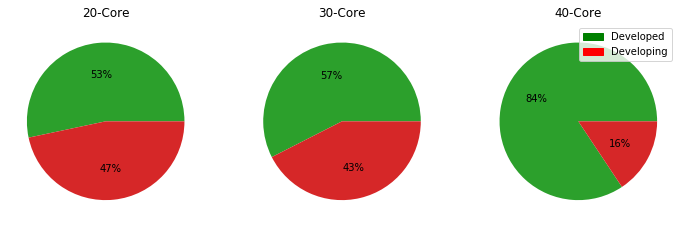

<Figure size 14400x14400 with 0 Axes>

In [53]:
# 6. K-Cores
# k-core = subgraph containing only vertices of degree k, which means that each vertex is adjacent to at least k other vertices
# This step is intending to show the percentage of airports from the developing world within those k-cores. 

# remove all edges from network
G.remove_edges_from(networkx.selfloop_edges(G))

# determine cores of degree 20, 30 and 40
G_core_20 = list(networkx.k_core(G, 20))
G_core_30 = list(networkx.k_core(G, 30))
G_core_40 = list(networkx.k_core(G, 40))

# Compute ratio for 20-Core
counter_developed_1 = 0
counter_developing_1 = 0
for node in G_core_20:
    if node in developed_list:
        counter_developed_1 += 1
    else:
        counter_developing_1 += 1
p_20 = [counter_developed_1, counter_developing_1]
colors = ['tab:green', 'tab:red']

# Compute ratio for 30-Core
counter_developed_2 = 0
counter_developing_2 = 0
for node in G_core_30:
    if node in developed_list:
        counter_developed_2 += 1
    else:
        counter_developing_2 += 1
p_30 = [counter_developed_2, counter_developing_2]
colors = ['tab:green', 'tab:red']

# Compute ratio for 40-Core
counter_developed_3 = 0
counter_developing_3 = 0
for node in G_core_40:
    if node in developed_list:
        counter_developed_3 += 1
    else:
        counter_developing_3 += 1
p_40 = [counter_developed_3, counter_developing_3]
colors = ['tab:green', 'tab:red']


# Plot figures
plt.figure(figsize=(12, 48))

plt.subplot(131)
plt.pie(p_20, colors = colors, autopct='%.0f%%')
plt.title('20-Core')

plt.subplot(132)
plt.pie(p_30, colors = colors, autopct='%.0f%%')
plt.title('30-Core')

plt.subplot(133)
plt.pie(p_40, colors = colors, autopct='%.0f%%')
plt.title('40-Core')

red_patch = mpatches.Patch(color='red', label='Developing')
green_patch = mpatches.Patch(color='green', label='Developed')
plt.legend(handles=[green_patch, red_patch])

plt.figure(figsize=(200, 200))

plt.show()